In [16]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
import IPython.display

from audio_segment import AudioSegment
from visualizers import vis_spec

# Damaged Sample

Normalize size of input array

In [27]:
D_agnus_dei = '../../data/audio_sources/wav/damaged/izotope_agnus_dei.wav'
D = AudioSegment(D_agnus_dei, duration=12.25)

print(D.audio.size, D.audio.shape, D.sample_rate)

540225 (540225,) 44100


Extract Mel-Scale features

135168 (128, 1056)


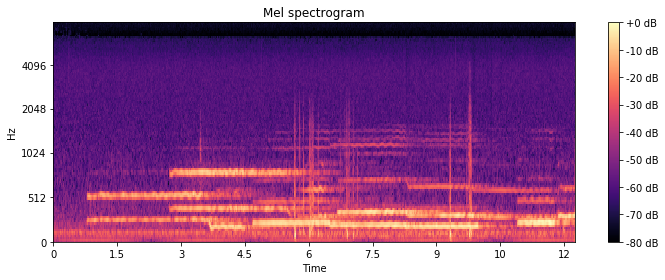

In [28]:
# We'll use melspectogram features since they can be inversed
D_full = D.mel_features

print(D_full.size, D_full.shape)
vis_spec(D_full)

Background and Foreground Masking

In [29]:
# https://librosa.github.io/librosa/0.7.0/auto_examples/plot_vocal_separation.html#vocal-separation
# Code source: Brian McFee
# License: ISC

In [30]:
def apply_filter(S:np.ndarray, sr:int) -> tuple:
    S_filter = librosa.decompose.nn_filter(S,
                                           aggregate=np.median,
                                           metric='cosine',
                                           width=int(librosa.time_to_frames(2, sr=sr)))

    S_filter = np.minimum(S, S_filter)

    margin_i, margin_v = 2, 10
    power = 2

    mask_i = librosa.util.softmask(S_filter,
                                   margin_i * (S - S_filter),
                                   power=power)

    mask_v = librosa.util.softmask(S - S_filter,
                                   margin_v * S_filter,
                                   power=power)

    
    return (mask_i, mask_v)

In [31]:
def save_checkpoints(checkpoints):
    """
    np.save(file)
    np.load(file)
    """
    for name, output in checkpoints:   
        with open(f'checkpoints/{name}.pkl', 'wb') as f:
            np.save(f, output)
    
    print("saved")
    

In [32]:
def plot_separation(full, bg, fg, sr):
    plt.figure(figsize=(12, 8))
    plt.subplot(3, 1, 1)
    librosa.display.specshow(librosa.amplitude_to_db(full, ref=np.max),
                             y_axis='log', sr=sr)
    plt.title('Full spectrum')
    plt.colorbar()

    plt.subplot(3, 1, 2)
    librosa.display.specshow(librosa.amplitude_to_db(bg, ref=np.max),
                             y_axis='log', sr=sr)
    plt.title('Background')
    plt.colorbar()
    plt.subplot(3, 1, 3)
    librosa.display.specshow(librosa.amplitude_to_db(fg, ref=np.max),
                             y_axis='log', x_axis='time', sr=sr)
    plt.title('Foreground')
    plt.colorbar()
    plt.tight_layout()
    plt.show()

saved


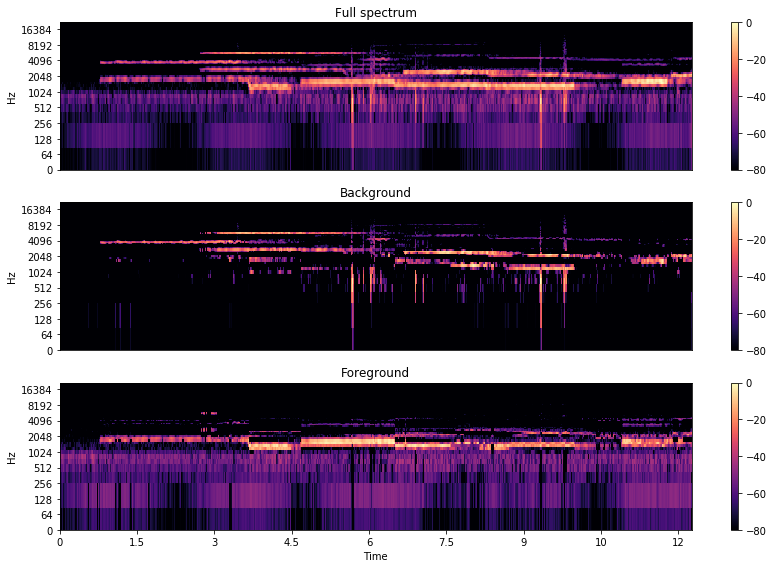

In [33]:
D_fg_mask, D_bg_mask = apply_filter(D_full, D.sample_rate) 
D_foreground = D_fg_mask * D_full
D_background = D_bg_mask * D_full

D_checkpoints = [
    ('D_foreground', D_foreground),
    ('D_background', D_background),
    ('D_full', D_full),
    ('D_fg_mask', D_fg_mask),
]

save_checkpoints(D_checkpoints)
plot_separation(D_full, D_background, D_foreground, sr=D.sample_rate)

# Ground Truth Sample

In [11]:
G_agnus_dei = '../../data/audio_sources/wav/gt/izotope_agnus_dei.wav'
G = AudioSegment(G_agnus_dei, duration=12.25)

print(G.audio.size, G.audio.shape, G.sample_rate)

540225 (540225,) 44100


135168 (128, 1056)


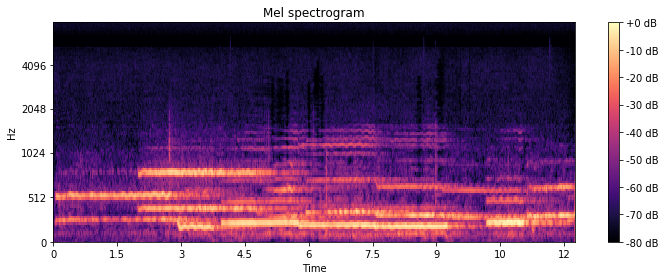

In [12]:
G_full = G.mel_features

print(G_full.size, G_full.shape)
vis_spec(G_full)

saved


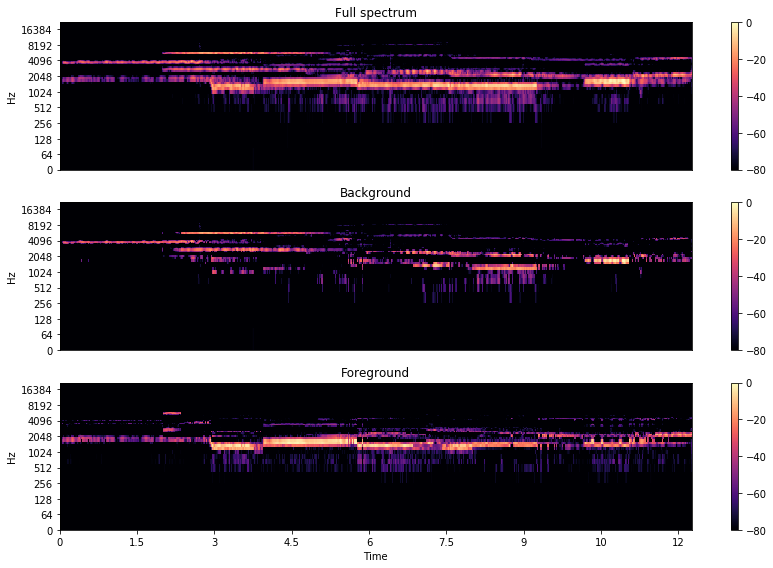

In [34]:
G_fg_mask, G_bg_mask = apply_filter(G_full, G.sample_rate) 
G_foreground = G_fg_mask * G_full
G_background = G_bg_mask * G_full

G_checkpoints = [
    ('G_foreground', G_foreground),
    ('G_background', G_background),
    ('G_full', G_full),
    ('G_fg_mask', G_fg_mask),
]

save_checkpoints(G_checkpoints)
plot_separation(G_full, G_background, G_foreground, sr=G.sample_rate)

In [23]:
G_audio = G.mel_to_audio(G_foreground/G_fg_mask,)

In [24]:
IPython.display.Audio(G_audio, rate=G.sample_rate)